# MobileNet - Integrisani gradijent

Učitavanje potrebnih biblioteka.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import torch.nn.functional as F

/Users/danilokacanski/Desktop/AUS Master/DL/DL/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Izbor na kom delu računara će se izvršavati kod.

In [2]:
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='mps')

Učitavanje MobileNet v3 modela, koje je najlakše na ovaj nalin uraditi. On je već treniran tako da njegovim stavljanjem u evaluacioni mod je spreman za sprovođenje predikcije.

In [4]:
model = torchvision.models.mobilenet_v3_large(weights="DEFAULT")
model.eval().to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Potrebno je definisati pipline za preprocesiranje kako bi model dobio slike u formatu u kojem ih očekuje.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Učitavanje određene slike da bi videli kako IG metoda zpravo radi. Zbog **problema sa relativnim putanjama** ovde se koristi **apsolutna** koja se možem dobiti njenim kopiranjem što je dostupno u praktično svakom IDE-u ili na bilo koji drugi način. **Slike su preuzete sa CalTech-ovog sajta**, ne želeći da preuzmem ceo ImageNet skup slika nego samo bilo šta slično što je manje 1GB, u ovom slučaju oko 150 MB, iako se ne radi o istim, već sličnim kalasama, taman radi ispitivanja na novim podacima.

In [6]:
img_path = "/Users/danilokacanski/Desktop/AUS Master/DL/DL/MobileNet/caltech-101/101_ObjectCategories/starfish/image_0007.jpg"
original_img = Image.open(img_path).convert('RGB')
input_tensor = transform(original_img).unsqueeze(0).to(device)

Pravljenje predikcija od strane modela koji je kao što je već rečeno treniran.

In [7]:
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
confidence = F.softmax(output, dim=1)[0, pred_class].item()

Prikaz originalne slike u RGB formatu uz **ispis predviđene klase i verovatnoće sa kojom je ona predviđena**.

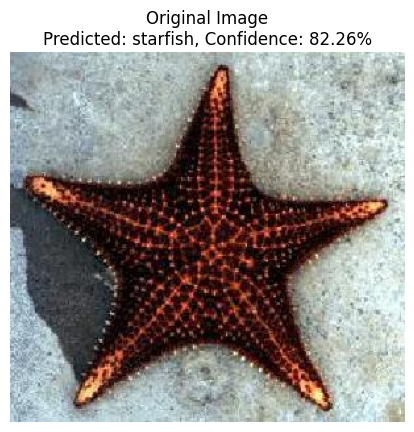

In [8]:
from torchvision.models import MobileNet_V3_Large_Weights

class_names = MobileNet_V3_Large_Weights.DEFAULT.meta["categories"]
pred_label = class_names[pred_class]
plt.imshow(original_img)
plt.title(f"Original Image\nPredicted: {pred_label}, Confidence: {confidence:.2%}")
plt.axis('off')
plt.show()

Pomoćna funkcija koja se koristi za računanje značaja piksela.

In [9]:
def attribute_image_features(algorithm, input, baselines=None, **kwargs):
    if baselines is None:
        baselines = input * 0
    return algorithm.attribute(input, baselines=baselines, **kwargs)

Za računanje IG koristi se **instanca objekta klase IntegratedGradients** iz biblioteke *captum*. **Paziti pri više pokretanja**,  radi menjanja parametara *n_steps* koji kontroliše koliko podeoka ima Rimanova suma tj. diskretizovan integral. *Nije toliki problem pri prvom pokretanju koliko god veliki bio (ne ići preko 300)*, **već pri sledećem jer kako warning/greška kaže *jede* memoriju**.

In [10]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, input_tensor,
    target=pred_class,
    n_steps=200,
    return_convergence_delta=True
)

attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print("Approximation delta:", abs(delta))

Approximation delta: tensor([0.1230], device='mps:0')


Prava definicija integrisanih gradijenata glasi:

$$
IG_i(x) = (x_i - x'_i) \cdot \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha(x - x'))}{\partial x_i} d\alpha
$$

Pošto se integral ne može izračunati analitički, koristi se numerička aproksimacija:

$$
IG_i^{approx}(x) = (x_i - x'_i) \cdot \sum_{k=1}^{m} \frac{\partial F(x' + \frac{k}{m}(x - x'))}{\partial x_i} \cdot \frac{1}{m}
$$

 U kodu se koristi *attribute()* metoda koja implementira numeričku aproksimaciju integrala.
- Vrednost `m` (broj koraka) je po defaultu `50`, što odgovara sumiranju gradijenata u 50 tačaka između baseline i stvarnog ulaza.
- `baseline = input * 0` predstavlja nultu informaciju, odnosno početak integracije.
- - `delta` označava razliku između promene predikcije modela $( F(x) - F(x') $) i sume integrisanih gradijenata po svim ulaznim dimenzijama. Idealno, delta bi trebalo da bude što bliža nuli.

Denormalizacija slike radi lepše vizualizacije.

In [11]:
def denormalize_tensor_image(tensor_img, mean, std):
    img = tensor_img.squeeze().cpu().detach().numpy()
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    img = img * std + mean
    img = np.transpose(img, (1, 2, 0))
    return np.clip(img, 0, 1)

In [12]:
original_image = denormalize_tensor_image(input_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Vizualizacija doprinosa IG:

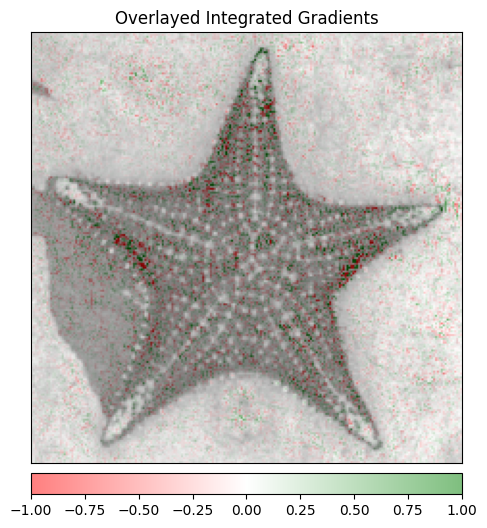

In [13]:
v = viz.visualize_image_attr(attr_ig, original_image,
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True,
                             title="Overlayed Integrated Gradients")

Verzije korišćenog softvera:
   - Python: 3.10+
   - torch: 2.2.1
   - torchvision: 0.17.1
   - captum: 0.6.0

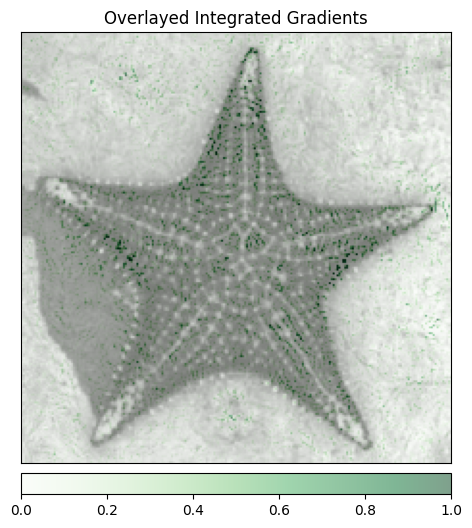

In [14]:
v = viz.visualize_image_attr(attr_ig, original_image,
                             method="blended_heat_map",
                             sign="positive",
                             show_colorbar=True,
                             title="Overlayed Integrated Gradients")